In [185]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.v2 as tfs

In [186]:
#Возьмем трансформер из сети VGG16
transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [188]:
#Сформирует класс для формирование сверточных слоёв
class ImageStyle(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg16(models.VGG16_Weights.DEFAULT).features
        self.model.to(device)
        self.model.requires_grad_(False)
        self.requires_grad_(False)
        self.indexs = [0, 5, 10, 17, 24, 28]
        self.content_index = self.indexs[-1]

    def forward(self, x):
        outputs = []
        for index, layer in enumerate(self.model):
            x = layer(x)
            if index in self.indexs:
                outputs.append(x.squeeze())
        return outputs

In [189]:
#Ошибка по контенту
def content_error(content_layer, total_layer):
    return torch.mean((content_layer.squeeze() - total_layer.squeeze())**2)

In [190]:
#Ошибка по стилю
def style_error(style_layer_list, total_layer_list):
    #Возьмем такие коэффициенты, чтобы больше учитывались более низкоуровневые паттерны
    coef_lambda = [0.25, 0.225, 0.2, 0.175, 0.15]
    errors = 0
    i = 0
    for style_layer, total_layer in zip(style_layer_list, total_layer_list):
        style_matrix = style_layer.view(style_layer.shape[0], -1)
        total_matrix = total_layer.view(total_layer.shape[0], -1)
        style_gramm = (style_matrix @ style_matrix.transpose(1, 0)) / style_matrix.shape[1]
        total_gramm = total_matrix @ total_matrix.transpose(1, 0) / total_matrix.shape[1]
        errors += torch.mean((total_gramm - style_gramm)**2) * coef_lambda[i]
        i += 1
    return errors

In [ ]:
#Импортирование изображений
concent_image = Image.open("Miracle.png").convert("RGB")
concent_image = transform(concent_image).unsqueeze_(0)
concent_image = concent_image.to(device)

#Изображение для стилизации
style_image = Image.open("style_image.webp").convert("RGB")
style_image = transform(style_image).unsqueeze_(0)
style_image = style_image.to(device)

#Итоговое изображение
total_image = concent_image.clone()
total_image.requires_grad_(True)

model = ImageStyle()
eph = 1000
content_layer = model(concent_image)[-1]
style_layers = model(style_image)[:-1]
coef_a, coef_b = 1, 5000
loss_func = loss_errors
optimizer = optim.Adam(params=[total_image], lr=0.01)
best_score = -1
for _e in range(eph):
    total_layers = model(total_image)
    content_error_ = content_error(total_layers[-1], content_layer)
    style_error_ = style_error(total_layers[:-1], style_layers)
    loss = coef_a * content_error_ + coef_b * style_error_

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_image.data.clamp_(0, 1)

    if loss < best_score or best_score < 0:
        best_score = loss.item()
        best_img = total_image.clone()

    print(f"Итерация: [{_e+1}/{eph}]  Ошибка: {round(best_score, 3)}")

C:\Users\sholo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Итерация: [1/1000]  Ошибка: 5429.817
Итерация: [2/1000]  Ошибка: 4642.13
Итерация: [3/1000]  Ошибка: 3918.376
Итерация: [4/1000]  Ошибка: 3279.801
Итерация: [5/1000]  Ошибка: 2736.968
Итерация: [6/1000]  Ошибка: 2269.107
Итерация: [7/1000]  Ошибка: 1877.41
Итерация: [8/1000]  Ошибка: 1567.505
Итерация: [9/1000]  Ошибка: 1325.597
Итерация: [10/1000]  Ошибка: 1136.641
Итерация: [11/1000]  Ошибка: 986.801
Итерация: [12/1000]  Ошибка: 864.898
Итерация: [13/1000]  Ошибка: 762.641
Итерация: [14/1000]  Ошибка: 675.508
Итерация: [15/1000]  Ошибка: 601.435
Итерация: [16/1000]  Ошибка: 538.612
Итерация: [17/1000]  Ошибка: 485.138
Итерация: [18/1000]  Ошибка: 439.572
Итерация: [19/1000]  Ошибка: 400.655
Итерация: [20/1000]  Ошибка: 367.178
Итерация: [21/1000]  Ошибка: 338.255
Итерация: [22/1000]  Ошибка: 312.982
Итерация: [23/1000]  Ошибка: 290.779
Итерация: [24/1000]  Ошибка: 271.192
Итерация: [25/1000]  Ошибка: 253.899
Итерация: [26/1000]  Ошибка: 238.582
Итерация: [27/1000]  Ошибка: 224.914
Ит

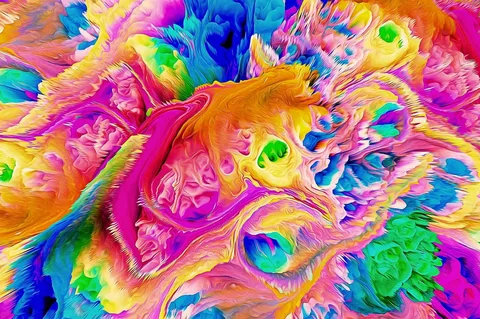

In [187]:
Image.open("style_image.webp").convert("RGB")

In [ ]:
best_img = best_img.to("cpu")
x = best_img.detach().squeeze()
low, hi = torch.amin(x), torch.amax(x)
x = (x - low) / (hi - low) * 255.0
x = x.permute(1, 2, 0)
x = x.numpy()
x = np.clip(x, 0, 255).astype('uint8')

image = Image.fromarray(x, 'RGB')
image.save("result.jpg")

print(f"Ошибка:{round(best_score, 3)}")
plt.imshow(x)
plt.show()

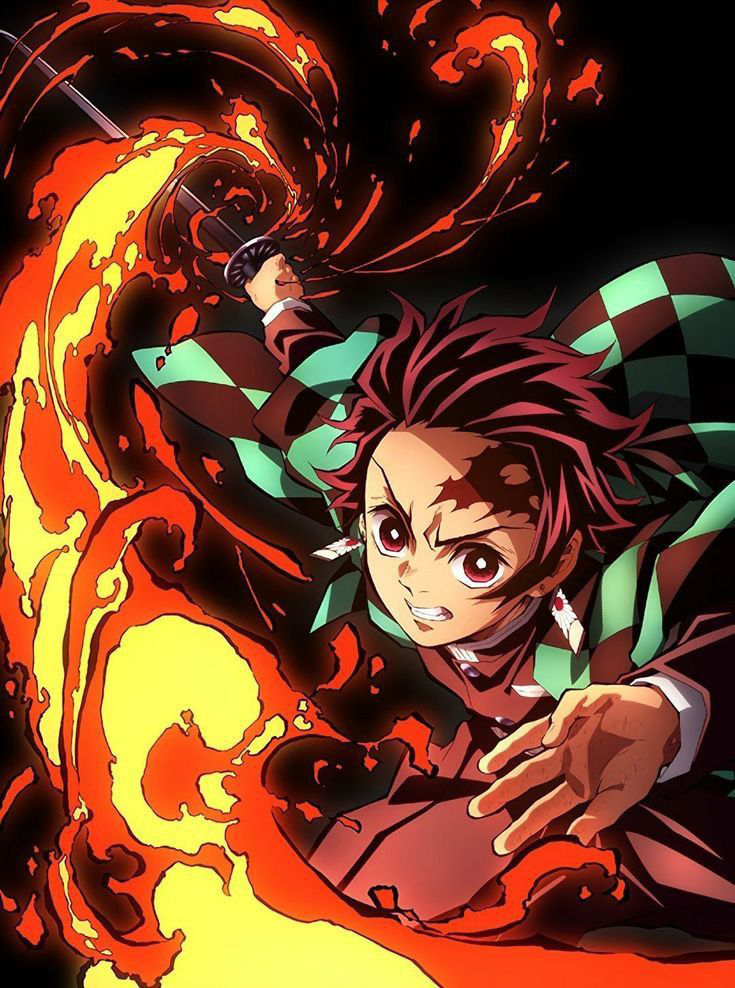

In [182]:
#Начальный результат


Ошибка:8.382


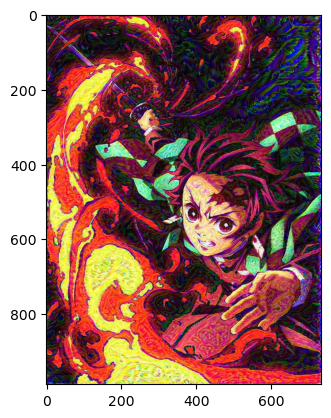

In [183]:
best_img = best_img.to("cpu")
x = best_img.detach().squeeze()
low, hi = torch.amin(x), torch.amax(x)
x = (x - low) / (hi - low) * 255.0
x = x.permute(1, 2, 0)
x = x.numpy()
x = np.clip(x, 0, 255).astype('uint8')

image = Image.fromarray(x, 'RGB')
image.save("result.jpg")

print(f"Ошибка:{round(best_score, 3)}")
plt.imshow(x)
plt.show()

In [184]:
x.shape

(988, 735, 3)